In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import sys
sys.path.append(".")  # Add current directory to Python path
sys.path.append("./../Example_Code")  # Add current directory to Python path
import utils
from datetime import datetime, timedelta
import calendar  # Smoothed line
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import json
import pickle

####   Arguments for choosing EMA and leadtime:


In [3]:
#### Arguments for selecting model checkpoints ####
EMA = False # Whether to use EMA checkpoints
lead_time = 5 # Lead time in days

In [4]:
event_name = "Ian"
initialize_5day_pre_event_date = "2022_09_24" # initialize for 5-day lead time
    # 9-29 is the main forecast date for Hurricane Ian
    # but 9-24 is the initialization date for 5-day lead time forecasts

Ian_fp = "/projectnb/eb-general/wade/sfno/inference_runs/Ian/"

if EMA:
    checkpoint_fp = os.path.join(Ian_fp, "EMA_leadtime_fivedays/") # model forecast from each checkpoint at time of event 
elif not EMA and lead_time == 5:
    checkpoint_fp = os.path.join(Ian_fp, "leadtime_fivedays/")
elif not EMA and lead_time == 3:
    checkpoint_fp = os.path.join(Ian_fp, "leadtime_threedays/")
elif not EMA and lead_time == 1:
    checkpoint_fp = os.path.join(Ian_fp, "leadtime_oneday/")

if EMA:
    reference_checkpoint_fp = os.path.join(Ian_fp, "Reference_EMA_fivedays/") # model forecast for each reference date from each checkpoint
else:
    reference_checkpoint_fp = os.path.join(Ian_fp, "Reference_fivedays/")
        # we don't have the one or three day lead time reference forecasts saved

initialize_data_fp = os.path.join(Ian_fp, "Initialize_data/") # ERA5 data at initialization times and nsteps afterwards

# Initialize empty dataframe to store metrics
checkpoint_numbers = np.arange(1,91)
metrics_df = pd.DataFrame(index=checkpoint_numbers)
metrics_df.index.name = 'Checkpoint'  # Set the index name
metrics_df.sort_index(inplace=True)  # Sort by Checkpoint number

# list reference dates from reference_checkpoint_fp
dates = os.listdir(reference_checkpoint_fp)
dates.sort()
dates.append(initialize_5day_pre_event_date) # The last date is the event date
dates = [f"{d}T00_nsteps20" for d in dates] #reformat to match checkpoint file format
initial_dates = [datetime.strftime(datetime.strptime(d, "%Y_%m_%dT%H_nsteps20")-timedelta(days = 5), "%Y_%m_%dT%H_nsteps20") for d in dates] #create intiialize date list

### Becca's code:

In [8]:
## Functions that allow you to add a metric, in this case difference between msl minimum, to a dataframe of metrics. 
def add_min_msl_diff_column(metrics_df, checkpoint_fp, era_truth_xr, variable, event_name, date = None):
    """
    Adds a column to metrics_df with them difference in variable minimum. This same type of function can be adopted to add other metrics.
    """

    print(f"Processing min MSL")
    reference_forecast = False
    # Check if the checkpoint file path contains "boring" to set the reference_forecast flag
    if "reference" in checkpoint_fp.lower():
        reference_forecast = True

    # Load the ERA5 truth data for the specific variable and time
    era_truth = trim_domain(era_truth_xr, event_name)

    # Get sorted checkpoint files
    checkpoint_files = get_sorted_checkpoint_files(checkpoint_fp) 

    if not checkpoint_files:
        print(f"No checkpoint files found in {checkpoint_fp}. Aborting calculation.")
        return metrics_df # Return original df if no files

    temp_minmax_dict = {} # Use a dictionary to store 
    first_file_processed_flag = True # Flag to check only the first file

    for checkpoint_num, filename in checkpoint_files:
        file_path = os.path.join(checkpoint_fp, filename)
        
        one_checkpoint = xr.open_dataset(file_path)[variable]
        one_checkpoint = trim_domain(one_checkpoint, event_name)
        
        temp_minmax_dict[checkpoint_num] = minmax_metric(one_checkpoint, era_truth, "min", dims=None)

    minmax_column_name = f"min_{variable}_{event_name}"
    if reference_forecast:
        minmax_column_name = f"reference_{date[:10]}"

    metrics_df[minmax_column_name] = metrics_df.index.map(temp_minmax_dict)
    
    print(f"Column '{minmax_column_name}' added/updated.")
    return metrics_df

def trim_domain(dataset, event_name):
    """
    Returns of the dataset trimmed to the domain of interest for the specified event. Can modify for different events.
    """
    if event_name == "Ian":
        lat_min, lat_max = 23, 32
        lon_min, lon_max = -89, -74
        if "lon" and "lat" in dataset.coords:
            return dataset.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min% 360, lon_max% 360))
        if "longitude" and "latitude" in dataset.coords:
            return dataset.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min% 360, lon_max% 360))

def get_sorted_checkpoint_files(checkpoint_fp):
    """
    Returns a sorted list of checkpoint files based on checkpoint numbers.
    """
    # Get a list of checkpoint files and extract checkpoint numbers
    checkpoint_files_with_numbers = []
    for filename in os.listdir(checkpoint_fp):
        if filename.startswith("Checkpoint"):
            match = re.search(r'Checkpoint(\d+)_', filename)
            if match:
                checkpoint_number = int(match.group(1))
                checkpoint_files_with_numbers.append((checkpoint_number, filename))
    # Sort the checkpoint files based on the checkpoint number
    checkpoint_files_with_numbers.sort(key=lambda x: x[0])
    return checkpoint_files_with_numbers

def minmax_metric(a, b, minmax_select, dims=None):
    """
    Compute difference between the minimum values in two xarray objects over all spatial dims (and time if present).
    Returns a single float if all dims are reduced.

    """
    # If dims not specified, use all dims in the data
    if dims is None:
        dims = list(a.dims)

    if minmax_select == "min":
        diff = float(np.min(a.values) - np.min(b.fields.values))
    elif minmax_select == "max":
        diff = float(np.max(a.values) - np.max(b.fields.values))    
    else:
        raise ValueError(f"Invalid minmax_select: {minmax_select}. Must be 'min' or 'max'.")
        
    return diff


## Make a pandas dataframe with reference and event metric

In [30]:
# print(dates)
for date in dates:
    if date != f"{initialize_5day_pre_event_date}T00_nsteps20": 
        print("CONDITION 1")
        print(date)
    else:
        print("CONDITION 2")
        print(date)

CONDITION 1
2019_09_01T00_nsteps20
CONDITION 1
2019_09_02T00_nsteps20
CONDITION 1
2019_09_03T00_nsteps20
CONDITION 1
2019_09_04T00_nsteps20
CONDITION 1
2019_09_05T00_nsteps20
CONDITION 1
2019_09_06T00_nsteps20
CONDITION 1
2019_09_07T00_nsteps20
CONDITION 1
2019_09_08T00_nsteps20
CONDITION 1
2019_09_09T00_nsteps20
CONDITION 1
2019_09_10T00_nsteps20
CONDITION 1
2019_09_11T00_nsteps20
CONDITION 1
2019_09_12T00_nsteps20
CONDITION 1
2019_09_13T00_nsteps20
CONDITION 1
2019_09_14T00_nsteps20
CONDITION 1
2019_09_15T00_nsteps20
CONDITION 1
2019_09_16T00_nsteps20
CONDITION 1
2019_09_17T00_nsteps20
CONDITION 1
2019_09_18T00_nsteps20
CONDITION 1
2019_09_19T00_nsteps20
CONDITION 1
2019_09_20T00_nsteps20
CONDITION 1
2019_09_21T00_nsteps20
CONDITION 1
2019_09_22T00_nsteps20
CONDITION 1
2019_09_23T00_nsteps20
CONDITION 1
2019_09_24T00_nsteps20
CONDITION 1
2019_09_25T00_nsteps20
CONDITION 1
2019_09_26T00_nsteps20
CONDITION 1
2019_09_27T00_nsteps20
CONDITION 1
2019_09_28T00_nsteps20
CONDITION 1
2019_09_

In [ ]:
# Ideally you run this once and save a csv with the results. Then load that csv next time.

for date in list(dates):
    print(date)
    # if "2022_09_28" in date:
    #     print("SKIPPING 2022_09_28 DATE DUE TO MISSING Initialize_ FILE")
    #     continue
    # if "2022_09_26" in date:
    #     print("SKIPPING 2022_09_26 DATE DUE TO MISSING Initialize_ FILE")
    #     continue
    # Check whether there is a matching Initialize_ file for this date
    fp = f"{initialize_data_fp}Initialize_"+date+".nc"
    if not os.path.isfile(fp):
        print(f"Skipping date {date} as Initialize_ file not found at {fp}")
        continue

    if date != f"{initialize_5day_pre_event_date}T00_nsteps20": # IF NOT THE INITIALIZATION DATE CORRESPONDING TO THE EVENT
        era_truth_xr = xr.open_dataset(fp).sel(variable="msl").isel(time=-1)

        metrics_df = add_min_msl_diff_column(metrics_df= metrics_df,
                                           checkpoint_fp=f"{reference_checkpoint_fp}{date[:10]}/", 
                                           era_truth_xr= era_truth_xr, 
                                           variable = "msl" , 
                                           event_name = event_name,
                                           date = date)
    else: # IF THE DATE OF THE EVENT:
        era_truth_xr = xr.open_dataset(fp).sel(variable="msl").isel(time=-1) # Becca prev. had: f"/barnes-engr-scratch2/C837824079/Experiment7/Initialize_data/Initialize_"+date+".nc").sel(variable="msl").isel(time=-1)
        metrics_df = add_min_msl_diff_column(metrics_df= metrics_df,
                                           checkpoint_fp=checkpoint_fp, # Q: WHY IS THE CHECKPOINT_FP DIFFERENT HERE?
                                           era_truth_xr= era_truth_xr, 
                                           variable = "msl" , 
                                           event_name = event_name
                                           # Q: WHY IS THERE NO DATE PARAMETER HERE?
                                           )

In [ ]:
metrics_df = np.abs(metrics_df) # absolute difference
metrics_df = metrics_df/ 100  # convert to hPa
metrics_df

# # save metrics 
# metrics_df.to_csv("min_msl_metric.csv")


In [5]:
# open saved metrics
loaded_metrics_df = pd.read_csv("min_msl_metric.csv", index_col=0)

In [33]:
# are there repeats in the column names?
cols = metrics_df.columns
cols_unique = set()
for col in cols:
    if col in cols_unique:
        print(f"Duplicate column name found: {col}")
    else:
        cols_unique.add(col)

Initialize files contains two timesteps of ERA5 data: one of the initialization and one of the forecast time.

## Plotting

In [ ]:
reference_metrics = metrics_df[[col for col in metrics_df.columns if 'reference' in col.lower()]]
event_metrics = metrics_df[[col for col in metrics_df.columns if 'reference' not in col.lower()]]

reference_metrics_smooth = reference_metrics.apply(gaussian_filter, sigma=3)
event_metrics_smooth = event_metrics.apply(gaussian_filter, sigma=3)

min_event = event_metrics_smooth.idxmin().item()

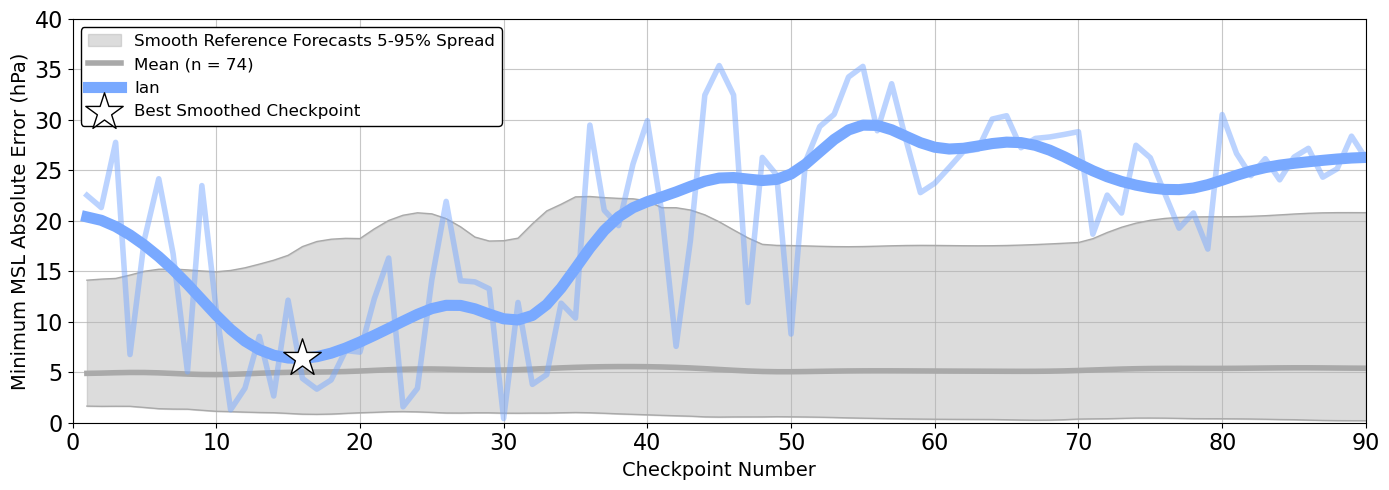

In [25]:
fig, ax1 = plt.subplots(figsize=(14, 5))

reference_color = "darkgrey"
event_color = '#79a9ff'

# Calculate mean and 10th/90th percentiles for reference columns
reference_mean = reference_metrics_smooth.mean(axis=1)
reference_p10 = reference_metrics_smooth.quantile(0.05, axis=1)
reference_p90 = reference_metrics_smooth.quantile(.95, axis=1)
reference_label = f'Smooth Reference Forecasts'

# Plot the reference spread (10-90% quantile)
ax1.fill_between(metrics_df.index, reference_p10, reference_p90, color=reference_color, alpha=0.4, label=f'{reference_label} 5-95% Spread', zorder =1)

# Plot the reference mean and 10th/90th percentiles
ax1.plot(metrics_df.index, reference_mean, linestyle='-', color=reference_color, alpha=1, linewidth=4, markersize=8, label=f'Mean (n = {reference_metrics.shape[1]})')
ax1.plot(metrics_df.index, reference_p10, linestyle='-', color=reference_color, alpha=1, linewidth=1, markersize=8)
ax1.plot(metrics_df.index, reference_p90, linestyle='-', color=reference_color, alpha=1, linewidth=1, markersize=8)

# plot event and smoothed event
ax1.plot(metrics_df.index, event_metrics, linestyle='-', color= event_color, alpha=.5, linewidth=4, markersize=5)
ax1.plot(metrics_df.index, event_metrics_smooth, linestyle='-', color= event_color, alpha=1, linewidth=8, markersize=5, label=f'{event_name}')
# plot best smoothed checkpoint
ax1.scatter(min_event, event_metrics_smooth.loc[min_event], marker = "*", color='black', facecolor = "white", s=800, zorder=5, label='Best Smoothed Checkpoint')


ax1.set_xlabel('Checkpoint Number', fontsize=14)
ax1.set_xlim(0, 90)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], fontsize=16)

ax1.set_ylabel('Minimum MSL Absolute Error (hPa)', fontsize=14)
ax1.set_ylim(0, 40)

plt.grid(True, alpha=0.7)

plt.yticks(fontsize=16)
plt.tight_layout()
legend = plt.legend(
    fontsize='large',
    edgecolor='black', 
    facecolor='white', framealpha=1)


# plt.savefig(f"figure.png", dpi=300, bbox_inches='tight')


In [6]:
# Function to open and print one dataset from a directory
def open_and_print_dataset(directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory) if f.endswith(".nc")]
    if not files:
        print(f"No .nc files found in {directory}")
        return
    
    # Open the first file
    file_path = os.path.join(directory, files[0])
    print(f"Opening file: {file_path}")
    dataset = xr.open_dataset(file_path)
    
    #print the variables in the dataset
    print("Variables in the dataset:", dataset.data_vars)
    
    # Print the dataset
    print(dataset)

# Open and print datasets from each directory
print("Initialize_data:")
open_and_print_dataset(initialize_data_fp)

print("\nLeadtime_fivedays:")
open_and_print_dataset(checkpoint_fp)

print("\nReference_fivedays:")
open_and_print_dataset(reference_checkpoint_fp + dates[0][:10] + "/")  # Just checking the first date directory


Initialize_data:
Opening file: /projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_2022_09_12T00_nsteps20.nc
Variables in the dataset: Data variables:
    fields   (time, variable, lat, lon) float32 615MB ...
<xarray.Dataset> Size: 615MB
Dimensions:    (time: 2, variable: 74, lat: 721, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 16B 2022-09-12 2022-09-17
    grid_type  <U11 44B ...
  * lat        (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * variable   (variable) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'q925' 'q1000'
Data variables:
    fields     (time, variable, lat, lon) float32 615MB ...

Leadtime_fivedays:
Opening file: /projectnb/eb-general/wade/sfno/inference_runs/Ian/leadtime_fivedays/Checkpoint43_2022_09_24T00_nsteps20.nc
Variables in the dataset: Data variables:
    msl      (valid_time, lat, lon) float32 4MB ...
    u10m     (valid_time, l

### Now, let's pivot the analysis to look at *ONE* grid cell location, and what the model error is across the inference runs we have
#### - leadtime: 5 days
#### - location: location with minimum msl on the day when Ian made landfall
#### - error: difference between forecasted msl and ERA5 msl
#### - models: using all 90 checkpoints
#### - dates: all dates in Reference_fivedays that we also have Initialize files for, as well as the files in leadtime_fivedays which are the day of hurricane ian landfall



First, identify the location (lat,lon) of minimum msl on the day of Hurricane Ian's landfall from the ERA5 data.

In [9]:
ian_event_date = "2022_09_24"
ian_initialize_fp = f"{initialize_data_fp}Initialize_{initialize_5day_pre_event_date}T00_nsteps20.nc"
ian_initialize_ds = xr.open_dataset(ian_initialize_fp)
ian_09_24 = ian_initialize_ds.sel(variable="msl").isel(time=-1)
# Trim to Ian domain
ian_09_24_trimmed = trim_domain(ian_09_24, event_name)
print(ian_09_24_trimmed)

# find the lat_index, and lon_index of the minimum msl value in the trimmed dataset
array = ian_09_24_trimmed.fields.values # this is an array with dimensions (lat, lon)
min_idx = np.unravel_index(np.argmin(array, axis=None), array.shape)
print(f"Minimum MSL index on {ian_event_date} is at {min_idx}")
    
# Extract the latitude and longitude of the minimum value
min_lat = ian_09_24_trimmed["lat"].isel(lat=min_idx[0])
min_lon = ian_09_24_trimmed["lon"].isel(lon=min_idx[1])

print(f"Minimum MSL on {ian_event_date} is at lat: {min_lat.values}, lon: {min_lon.values}")

<xarray.Dataset> Size: 10kB
Dimensions:    (lat: 37, lon: 61)
Coordinates:
    time       datetime64[ns] 8B 2022-09-29
    grid_type  <U11 44B ...
  * lat        (lat) float64 296B 32.0 31.75 31.5 31.25 ... 23.5 23.25 23.0
  * lon        (lon) float64 488B 271.0 271.2 271.5 271.8 ... 285.5 285.8 286.0
    variable   <U5 20B 'msl'
Data variables:
    fields     (lat, lon) float32 9kB ...
Minimum MSL index on 2022_09_24 is at (np.int64(20), np.int64(29))
Minimum MSL on 2022_09_24 is at lat: 27.0, lon: 278.25


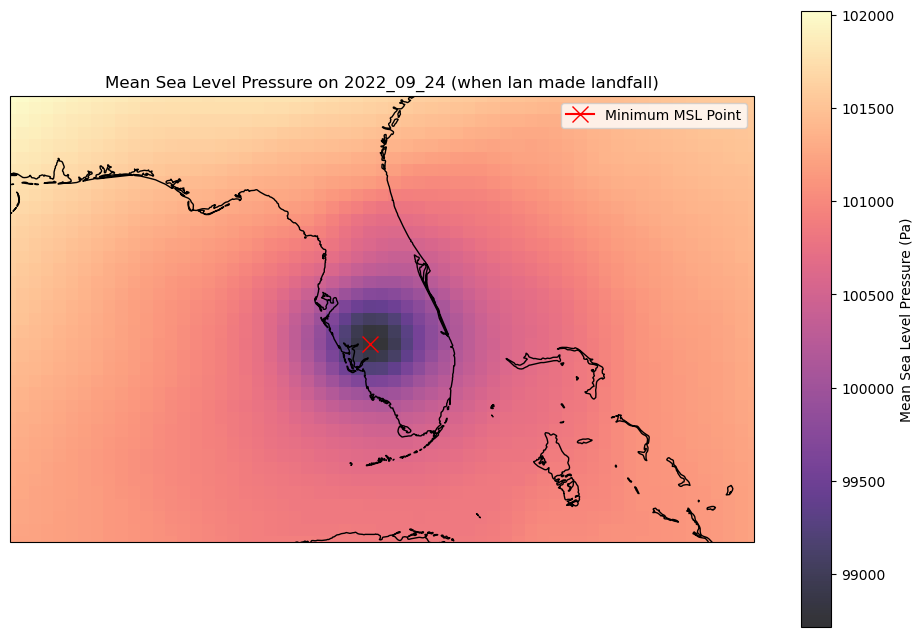

In [36]:
# map of the msl field for ian_09_24_trimmed and mark the minimum point
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ian_09_24_trimmed.fields.plot(ax=ax, cmap='magma', cbar_kwargs={'label': 'Mean Sea Level Pressure (Pa)'}, alpha=0.8)
ax.plot(min_lon.values-360 , min_lat.values , marker='x', color='red', markersize=12, label='Minimum MSL Point')
ax.set_title(f'Mean Sea Level Pressure on {ian_event_date} (when Ian made landfall)')
ax.coastlines()
ax.set_extent([-89, -74, 23, 32], crs=ccrs.PlateCarree())
ax.legend()
plt.show()

In [12]:
# For that location, track the error in MSL over all checkpoints for all dates
min_msl_errors = {
    # key: date
    # value: list of errors for each checkpoint
}
for date in list(dates):
    print(date)
    
    # Check whether there is a matching Initialize_ file for this date
    fp = f"{initialize_data_fp}Initialize_"+date+".nc"
    if not os.path.isfile(fp):
        print(f"Skipping date {date} as Initialize_ file not found at {fp}")
        continue

    era_truth_xr = xr.open_dataset(fp).sel(variable="msl").isel(time=-1)
    # print(era_truth_xr.sel(lat=min_lat.values, lon=min_lon.values).fields.values)
    # era_truth_xr = trim_domain(era_truth_xr, event_name)
    era_truth_value = era_truth_xr.sel(lat=min_lat.values, lon=min_lon.values).fields.values
    # print(f"ERA5 truth value at min point for date {date}: {era_truth_value}")
    
    checkpoint_files = get_sorted_checkpoint_files(
        f"{reference_checkpoint_fp}{date[:10]}/" if date != f"{initialize_5day_pre_event_date}T00_nsteps20" else checkpoint_fp
    )

    for checkpoint_num, filename in checkpoint_files:
        file_path = os.path.join(
            f"{reference_checkpoint_fp}{date[:10]}/" if date != f"{initialize_5day_pre_event_date}T00_nsteps20" else checkpoint_fp,
            filename
        )
        
        one_checkpoint = xr.open_dataset(file_path)[ "msl"]
        # one_checkpoint = trim_domain(one_checkpoint, event_name)
        checkpoint_value = one_checkpoint.sel(lat=min_lat.values, lon=min_lon.values).values
        # print(f"Checkpoint {checkpoint_num} value at min point for date {date}: {checkpoint_value}")
        
        error = abs(checkpoint_value - era_truth_value) # / 100  # convert to hPa
        
        if date not in min_msl_errors:
            min_msl_errors[date] = []
        if len(min_msl_errors[date]) < checkpoint_num:
            min_msl_errors[date].append(error)

2019_09_01T00_nsteps20
2019_09_02T00_nsteps20
2019_09_03T00_nsteps20
2019_09_04T00_nsteps20
2019_09_05T00_nsteps20
2019_09_06T00_nsteps20
2019_09_07T00_nsteps20
2019_09_08T00_nsteps20
2019_09_09T00_nsteps20
2019_09_10T00_nsteps20
2019_09_11T00_nsteps20
2019_09_12T00_nsteps20
2019_09_13T00_nsteps20
2019_09_14T00_nsteps20
2019_09_15T00_nsteps20
2019_09_16T00_nsteps20
2019_09_17T00_nsteps20
2019_09_18T00_nsteps20
2019_09_19T00_nsteps20
2019_09_20T00_nsteps20
2019_09_21T00_nsteps20
2019_09_22T00_nsteps20
2019_09_23T00_nsteps20
2019_09_24T00_nsteps20
2019_09_25T00_nsteps20
2019_09_26T00_nsteps20
Skipping date 2019_09_26T00_nsteps20 as Initialize_ file not found at /projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_2019_09_26T00_nsteps20.nc
2019_09_27T00_nsteps20
Skipping date 2019_09_27T00_nsteps20 as Initialize_ file not found at /projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_2019_09_27T00_nsteps20.nc
2019_09_28T00_nsteps20
Skipping

In [42]:
len(min_msl_errors['2022_09_24T00_nsteps20'])

90

In [11]:
EMA_leadtime_str = "_EMA_" if EMA else "_"
EMA_leadtime_str += f"leadtime_{lead_time}days"

In [49]:
# save min_msl_errors to a file (there are numpy arrays in the dict)
with open(f"min_msl_errors{EMA_leadtime_str}.pkl", "wb") as f:
    pickle.dump(min_msl_errors, f)

In [10]:
# open the min_msl_errors from file
with open(f"min_msl_errors{EMA_leadtime_str}.pkl", "rb") as f:
    min_msl_errors = pickle.load(f)

In [14]:
# use the percentiles to determine the percentile rank of the era5 truth value at the min point for each date
percentile_fp = "/projectnb/eb-general/wade/sfno/percentiles/percentile_values/percentiles_MSL_lat27.0_lon278.25.json"
# load the json file, which is formatted as "percentile_number": value
with open(percentile_fp, "r") as f:
    percentiles_data = json.load(f)

percentile_for_dates = {
    # key: date
    # value: percentile rank of the era5 truth value at the min point
}

for date, errors in min_msl_errors.items():
    # if date == f"{initialize_5day_pre_event_date}T00_nsteps20":
    #     continue  # Skip the event date itself
    # get the era5 truth value at the min point for this date
    fp = f"{initialize_data_fp}Initialize_"+date+".nc"
    era_truth_xr = xr.open_dataset(fp).sel(variable="msl").isel(time=-1)
    era_truth_value = era_truth_xr.sel(lat=min_lat.values, lon=min_lon.values).fields.values
    
    # determine the percentile of this value
    percentile_rank = None
    for percentile_str, value in percentiles_data.items():
        percentile = int(percentile_str)
        if era_truth_value <= value:
            percentile_rank = percentile
            break
    if percentile_rank is None:
        percentile_rank = 100  # If greater than all percentiles, assign 100th percentile

    print(f"Date: {date}, ERA5 Truth Value: {era_truth_value} Pa, Percentile Rank: {percentile_rank}")
    percentile_for_dates[date] = percentile_rank


Date: 2019_09_01T00_nsteps20, ERA5 Truth Value: 101338.1875 Pa, Percentile Rank: 15
Date: 2019_09_02T00_nsteps20, ERA5 Truth Value: 101246.625 Pa, Percentile Rank: 10
Date: 2019_09_03T00_nsteps20, ERA5 Truth Value: 101318.9375 Pa, Percentile Rank: 14
Date: 2019_09_04T00_nsteps20, ERA5 Truth Value: 101559.0 Pa, Percentile Rank: 35
Date: 2019_09_05T00_nsteps20, ERA5 Truth Value: 101841.875 Pa, Percentile Rank: 67
Date: 2019_09_06T00_nsteps20, ERA5 Truth Value: 101930.625 Pa, Percentile Rank: 75
Date: 2019_09_07T00_nsteps20, ERA5 Truth Value: 101642.875 Pa, Percentile Rank: 44
Date: 2019_09_08T00_nsteps20, ERA5 Truth Value: 101482.6875 Pa, Percentile Rank: 27
Date: 2019_09_09T00_nsteps20, ERA5 Truth Value: 101425.875 Pa, Percentile Rank: 22
Date: 2019_09_10T00_nsteps20, ERA5 Truth Value: 101369.6875 Pa, Percentile Rank: 18
Date: 2019_09_11T00_nsteps20, ERA5 Truth Value: 101318.8125 Pa, Percentile Rank: 14
Date: 2019_09_12T00_nsteps20, ERA5 Truth Value: 101333.1875 Pa, Percentile Rank: 15


In [45]:
# save percentile_for_dates to a json file
with open("percentile_for_dates.json", "w") as f:
    json.dump(percentile_for_dates, f)

In [15]:
# open the percentile_for_dates from file
with open("percentile_for_dates.json", "r") as f:
    percentile_for_dates = json.load(f)

In [20]:
# Bin the dates into 5 percentile bins and calculate the mean error for each bin at each checkpoint
percentile_bins = [ (0,1), (2,5), (6,10), (11,15), (16,20), (20,40), (41,60), (61,80), (81,100)
    # (0,5), (6,20), (21,40), (41,60), (61,80), (81,95), 
                # (96,100)
]
    # [(0,20), (21,40), (41,60), (61,80), (81,100)]

# Automatically generate bins_MAE, bins_MPE, and num_dates_in_bins using percentile_bins
bins_MAE = {bin_range: np.zeros((90,)) for bin_range in percentile_bins}
bins_MPE = {bin_range: np.zeros((90,)) for bin_range in percentile_bins}
num_dates_in_bins = {bin_range: 0 for bin_range in percentile_bins}

for date, percentile in percentile_for_dates.items():
    errors = min_msl_errors[date]
    # get the era5 truth value at the min point for this date
    fp = f"{initialize_data_fp}Initialize_"+date+".nc"
    era_truth_xr = xr.open_dataset(fp).sel(variable="msl").isel(time=-1)
    era_truth_value = era_truth_xr.sel(lat=min_lat.values, lon=min_lon.values).fields.values
    print(f"Processing date: {date}, Percentile: {percentile}, ERA5 Truth Value: {era_truth_value} Pa")

    for bin_range in bins_MAE.keys():
        if bin_range[0] <= percentile <= bin_range[1]:
            bins_MAE[bin_range] += np.array(errors).squeeze()
            bins_MPE[bin_range] += np.array(errors).squeeze() / era_truth_value
            num_dates_in_bins[bin_range] += 1
            break

# Calculate mean errors for each bin
for bin_range in bins_MAE.keys():
    if num_dates_in_bins[bin_range] > 0:
        bins_MAE[bin_range] /= num_dates_in_bins[bin_range]
        bins_MPE[bin_range] /= num_dates_in_bins[bin_range]

heatmap_data = np.array([bins_MAE[bin_range]/100 for bin_range in bins_MAE.keys()])  # convert to hPa and organize into 2D heatmap array

print(num_dates_in_bins)

Processing date: 2019_09_01T00_nsteps20, Percentile: 15, ERA5 Truth Value: 101338.1875 Pa
Processing date: 2019_09_02T00_nsteps20, Percentile: 10, ERA5 Truth Value: 101246.625 Pa
Processing date: 2019_09_03T00_nsteps20, Percentile: 14, ERA5 Truth Value: 101318.9375 Pa
Processing date: 2019_09_04T00_nsteps20, Percentile: 35, ERA5 Truth Value: 101559.0 Pa
Processing date: 2019_09_05T00_nsteps20, Percentile: 67, ERA5 Truth Value: 101841.875 Pa
Processing date: 2019_09_06T00_nsteps20, Percentile: 75, ERA5 Truth Value: 101930.625 Pa
Processing date: 2019_09_07T00_nsteps20, Percentile: 44, ERA5 Truth Value: 101642.875 Pa
Processing date: 2019_09_08T00_nsteps20, Percentile: 27, ERA5 Truth Value: 101482.6875 Pa
Processing date: 2019_09_09T00_nsteps20, Percentile: 22, ERA5 Truth Value: 101425.875 Pa
Processing date: 2019_09_10T00_nsteps20, Percentile: 18, ERA5 Truth Value: 101369.6875 Pa
Processing date: 2019_09_11T00_nsteps20, Percentile: 14, ERA5 Truth Value: 101318.8125 Pa
Processing date: 2

In [46]:
import cmocean

In [47]:
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

def plot_learning_heatmap(heatmap_array, percentile_bins, x_vals=np.arange(1, 91),
                          x_label='Model Checkpoint', y_label='Percentiles',
                          title=f'How does FourCastNetV2:EMA Learn Intensities of \nMean Sea Level Pressure at ({min_lat.values}°, {min_lon.values}°)?',
                          fp='sfno/percentiles/figs/msl_error_heatmap_custom.png',
                          cbar_args=dict(label='Average error in mean sea level pressure (hPa)'),
                          log_scale_colorbar=False, proportional_bin_size=False,
                          cmap=cmocean.cm.thermal, # 'RdYlGn_r'
                          ):
    if proportional_bin_size:
        # Calculate proportional heights for each bin
        bin_heights = [bin_range[1] - bin_range[0] for bin_range in percentile_bins]
        cumulative_heights = np.cumsum([0] + bin_heights)  # Cumulative heights for y-axis scaling

        # Normalize the heatmap array to match the proportional heights
        heatmap_array_resized = np.repeat(heatmap_array, bin_heights, axis=0)

        fig, ax = plt.subplots(figsize=(10, 4.5))
        if log_scale_colorbar:
            norm = mcolors.LogNorm(vmin=heatmap_array.min(), vmax=heatmap_array.max())
            cax = ax.imshow(heatmap_array_resized, aspect='auto', cmap=cmap, origin='lower',
                            extent=[0, len(x_vals), 0, cumulative_heights[-1]], norm=norm)
        else:
            cax = ax.imshow(heatmap_array_resized, aspect='auto', cmap=cmap, origin='lower',
                            extent=[0, len(x_vals), 0, cumulative_heights[-1]])

        # Set y-ticks to match the proportional bin heights
        ax.set_yticks(cumulative_heights[:-1] + np.array(bin_heights) / 2)
        ax.set_yticklabels([f"{bin_range[0]}-{bin_range[1]}%" for bin_range in percentile_bins])
    else:
        # Original plot with equal bin heights
        fig, ax = plt.subplots(figsize=(10, 4.5))
        if log_scale_colorbar:
            norm = mcolors.LogNorm(vmin=heatmap_array.min(), vmax=heatmap_array.max())
            cax = ax.imshow(heatmap_array, aspect='auto', cmap=cmap, origin='lower', norm=norm)
        else:
            cax = ax.imshow(heatmap_array, aspect='auto', cmap=cmap, origin='lower')

        ax.set_yticks(np.arange(len(percentile_bins)))
        ax.set_yticklabels([f"{bin_range[0]}-{bin_range[1]}%" for bin_range in percentile_bins])

    ax.set_xticks([0] + list(range(4, 90, 5)))
    ax.set_xticklabels([1] + list(range(5, 91, 5)))

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)

    # Reduce the gap between the colorbar and the plot
    cbar = fig.colorbar(cax, ax=ax, pad=0.01, **cbar_args)

    # Customize colorbar ticks
    if log_scale_colorbar:
        cbar_ticks = np.logspace(np.log10(heatmap_array.min()), np.log10(heatmap_array.max()), num=5)
        cbar.set_ticks(cbar_ticks)
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))
    else:
        cbar_ticks = np.linspace(heatmap_array.min(), heatmap_array.max(), num=5)
        cbar.set_ticks(cbar_ticks)
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    plt.title(title, fontsize=19)

    # Add text for sample sizes
    for i, bin_range in enumerate(percentile_bins):
        if proportional_bin_size:
            y_pos = cumulative_heights[i] + bin_heights[i] / 2
        else:
            y_pos = i
        sample_size = num_dates_in_bins[tuple(bin_range)]
        ax.text(len(x_vals) - 8, y_pos, f'n={sample_size}', va='center', fontsize=12, color='black')

    # mkdir if not exists
    os.makedirs(os.path.dirname(fp), exist_ok=True)
    plt.savefig(fp, dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
# def plot_learning_heatmap(heatmap_array, percentile_bins, x_vals=np.arange(1,91),
#                     x_label='Model Checkpoint', y_label='Percentiles', 
#                     title=f'How does FourCastNetV2:EMA Learn Intensities of \nMean Sea Level Pressure at ({min_lat.values}°, {min_lon.values}°)?',
#                     fp='sfno/percentiles/figs/msl_error_heatmap_custom.png', 
#                     cbar_args=dict(label='Average error in mean sea level pressure (hPa)')
#             ):
#     y_vals=[f"{bin_range[0]}-{bin_range[1]}%" for bin_range in percentile_bins]

#     fig, ax = plt.subplots(figsize=(10, 4.5))
#     cax = ax.imshow(heatmap_array, aspect='auto', cmap='RdYlGn_r', origin='lower')
#     ax.set_xticks([0] + list(range(4, 90, 5)))
#     ax.set_xticklabels([1] + list(range(5, 91, 5)))
#     ax.set_yticks(np.arange(len(percentile_bins)))
#     ax.set_yticklabels([f"{bin_range[0]}-{bin_range[1]}%" for bin_range in percentile_bins])

#     ax.set_xlabel(x_label, fontsize=18)
#     ax.set_ylabel(y_label, fontsize=18)
#     # reduce the gap between the colorbar and the plot
#     cbar = fig.colorbar(cax, ax=ax, pad=0.01, **cbar_args)
#     plt.title(title, fontsize=19)

#     # on the right side of theplot, for each percentile bin, add text saying n=sample_size_for_that_percentile_bin
#     for i, bin_range in enumerate(bins_MAE.keys()):
#         sample_size = num_dates_in_bins[bin_range]
#         ax.text(len(x_vals)-8, i, f'n={sample_size}', va='center', fontsize=12, color='black')

#     # mkdir if not exists
#     os.makedirs(os.path.dirname(fp), exist_ok=True)
#     plt.savefig(fp, dpi=300, bbox_inches='tight')
#     plt.show()

In [49]:
# get total number of dates processed
total_dates_processed = sum(num_dates_in_bins.values())
print(f"Total number of dates processed: {total_dates_processed}")

Total number of dates processed: 75


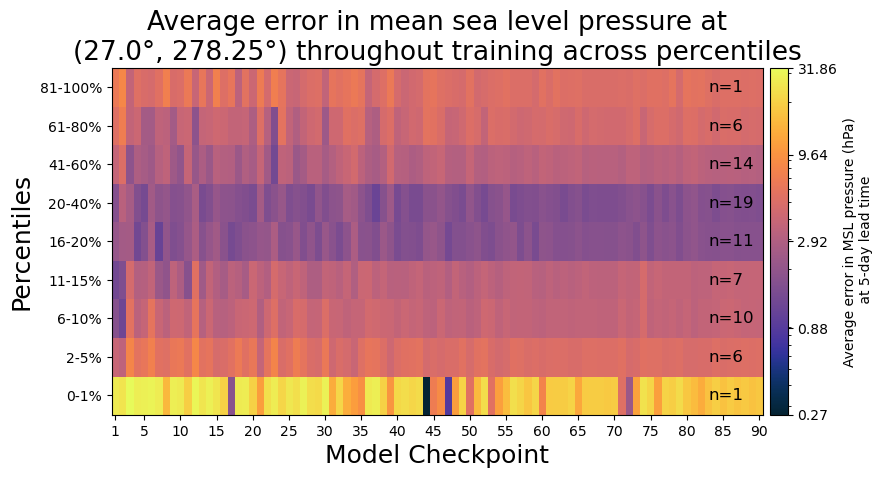

In [50]:
title = f"Average error in mean sea level pressure at\n({min_lat.values}°, {min_lon.values}°) throughout training across percentiles" 
if EMA: title += "\n[EMA checkpoints]"

plot_learning_heatmap(heatmap_array=heatmap_data, 
                    percentile_bins=list(bins_MAE.keys()),
                    # title=f'How does FourCastNetV2 Learn Intensities of \nMean Sea Level Pressure at ({min_lat.values}°, {min_lon.values}°)?',
                    title=title,
                    fp=f'./figs/{min_lat.values}_{min_lon.values}/msl_error_heatmap_raw{EMA_leadtime_str}.png',
                    cbar_args=dict(label=f'Average error in MSL pressure (hPa)\n at {lead_time}-day lead time'),
                    log_scale_colorbar=True, proportional_bin_size=False,
                    )


In [39]:
# Implement Gaussian smoothing on the heatmap data 
new_bin_MAE = {}
for bin_range in bins_MAE.keys(): # doing it per bin to ensure no smoothing between bins
    smoothed_errors = gaussian_filter(bins_MAE[bin_range], sigma=1)
    new_bin_MAE[bin_range] = smoothed_errors
MAE_heatmap = np.array([new_bin_MAE[bin_range]/100 for bin_range in new_bin_MAE.keys()])

# repeat for MPE
new_bin_MPE = {}
for bin_range in bins_MPE.keys():
    smoothed_errors = gaussian_filter(bins_MPE[bin_range], sigma=1)
    new_bin_MPE[bin_range] = smoothed_errors * 100  # convert to percent
MPE_heatmap = np.array([new_bin_MPE[bin_range] for bin_range in bins_MPE.keys()])

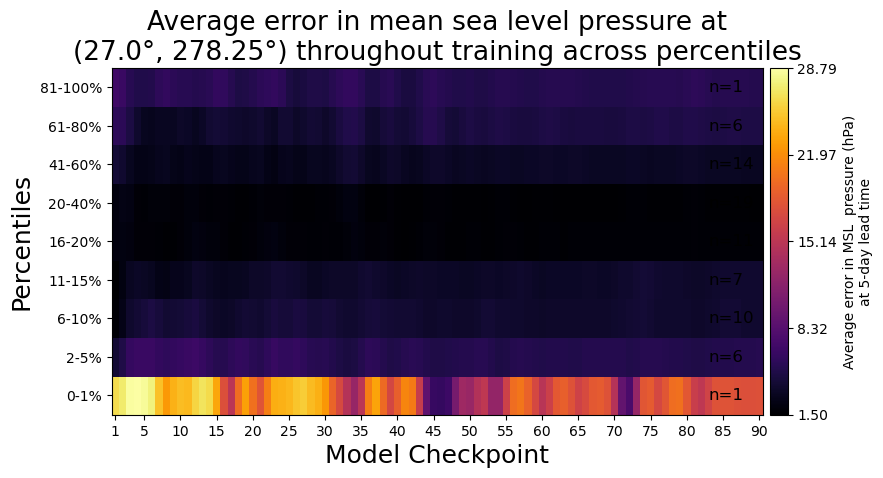

In [40]:
plot_learning_heatmap(
    heatmap_array=MAE_heatmap,
    percentile_bins=bins_MAE.keys(),
    # title=f'How does FourCastNetV2 Learn Intensities of \nMean Sea Level Pressure at ({min_lat.values}°, {min_lon.values}°)?',
    title=f"Average error in mean sea level pressure at\n({min_lat.values}°, {min_lon.values}°) throughout training across percentiles",
    fp=f"./figs/{min_lat.values}_{min_lon.values}/msl_error_heatmap_smoothed_EMA.png",
    cbar_args=dict(label='Average error in MSL  pressure (hPa)\nat 5-day lead time')
)


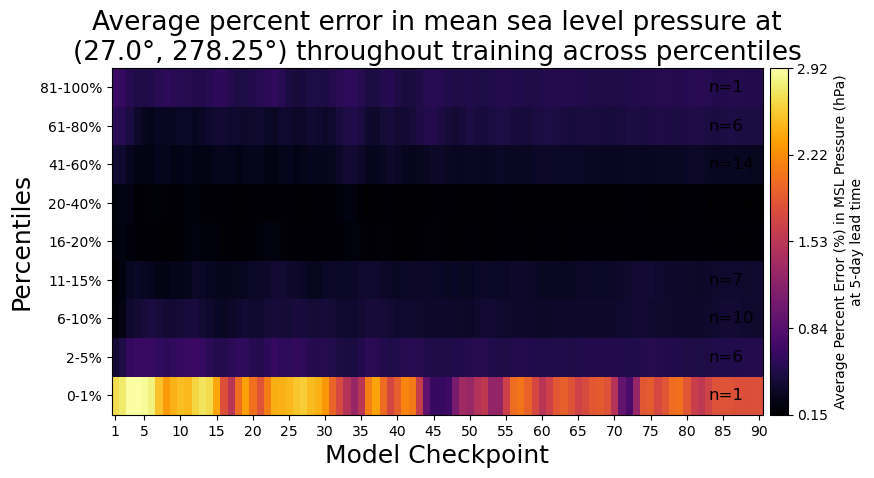

In [41]:
plot_learning_heatmap(
    heatmap_array=MPE_heatmap,
    percentile_bins=bins_MPE.keys(),
    # title=f'FourCastNetV2 Average Percent Error in Mean Sea Level\nat ({min_lat.values}°, {min_lon.values}°) throughout training across intensities',
    title=f"Average percent error in mean sea level pressure at\n({min_lat.values}°, {min_lon.values}°) throughout training across percentiles",
    fp=f"./figs/{min_lat.values}_{min_lon.values}/msl_percent_error_heatmap_smoothed_EMA.png",
    cbar_args=dict(label='Average Percent Error (%) in MSL Pressure (hPa)\nat 5-day lead time')
)


the below code is old/experimental

/scratch/383173.1.ood/ipykernel_2723775/802149564.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(dates))


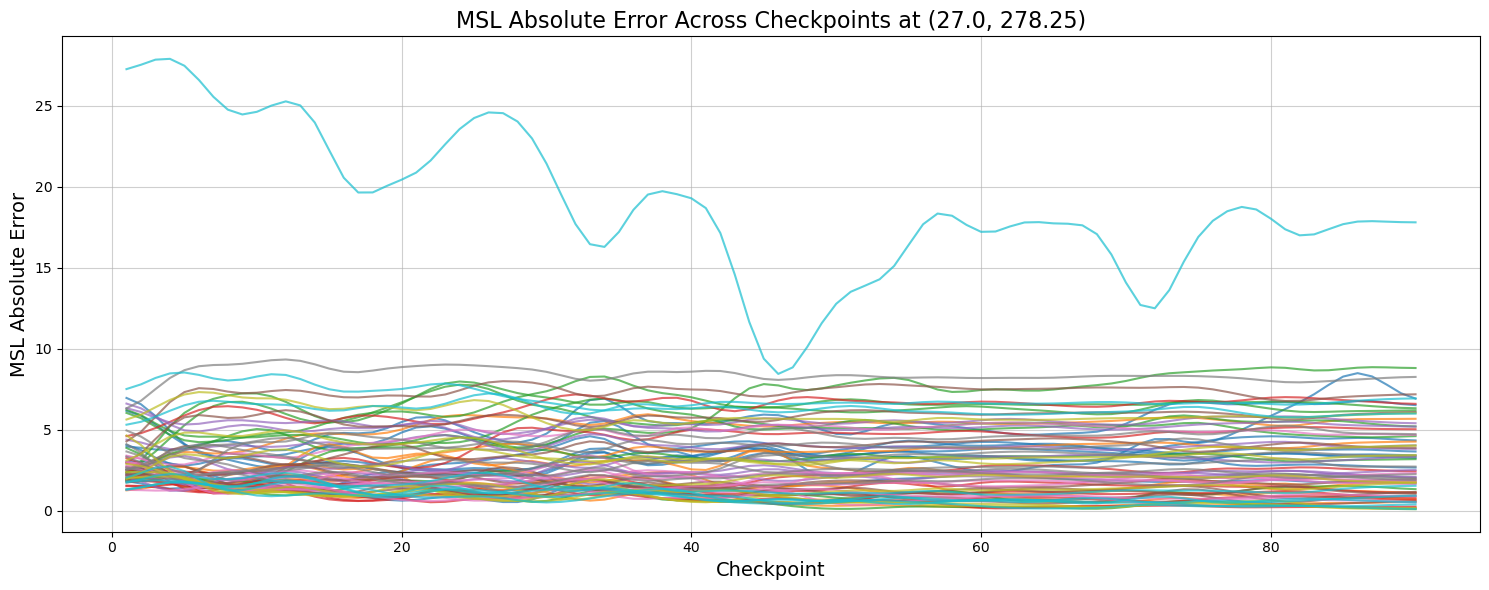

In [37]:
from datetime import datetime
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(15, 6))
format_string = "%Y_%m_%d"

dates = min_msl_errors.keys()
cmap = plt.cm.get_cmap('tab10', len(dates))
date_to_color = {date: cmap(i) for i, date in enumerate(dates)}

for ind, (date, errors) in enumerate(min_msl_errors.items()):
    # # convert the date to a number for calculating the color based on date
    # datetime_object = datetime.strptime(date[:10], format_string)
    # numerical_date_string = datetime_object.strftime("%Y%m%d")
    
    # color = plt.cm.copper(date_as_int / 100)  # Color based on date

    # make errors a pandas object so can apply .apply(gaussian_filter, sigma=2)
    errors = pd.DataFrame(errors)
    errors = errors.apply(gaussian_filter, sigma=2)
    ax.plot(range(1, len(errors) + 1), np.array(errors) / 100, color=date_to_color[date], alpha=0.7)
ax.set_xlabel('Checkpoint', fontsize=14)
ax.set_ylabel('MSL Absolute Error', fontsize=14)
ax.set_title(f'MSL Absolute Error Across Checkpoints at ({min_lat.values}, {min_lon.values})', fontsize=16)
# Add a categorical colorbar
# sm = plt.cm.ScalarMappable(cmap=ListedColormap([date_to_color[date] for date in dates]), norm=plt.Normalize(vmin=0, vmax=len(dates)))
# cbar = plt.colorbar(sm, ax=ax, pad=0.01, ticks=range(len(dates)))
# cbar.ax.set_yticklabels(dates)
# cbar.set_label('Date', fontsize=14)
# cbar.set_label('Date', fontsize=14)
plt.grid(True, alpha=0.6)
plt.tight_layout()
# plt.savefig(f"min_msl_error_across_checkpoints.png", dpi=300, bbox_inches='tight')
plt.show()

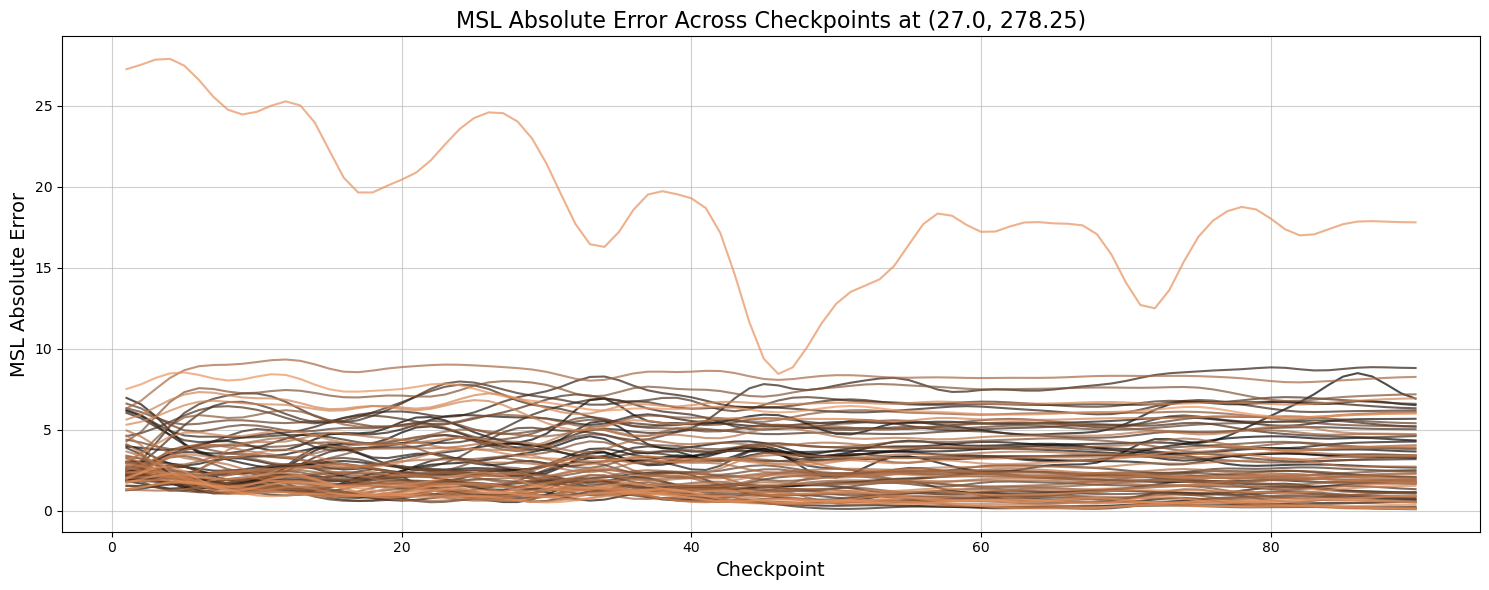

In [38]:
# Make a plot with checkpoint on the x-axis, and min msl error on the y-axis, with a separate line for each date, colored by the percentile rank of the era5 truth value at the min point
fig, ax = plt.subplots(figsize=(15, 6))
for ind, (date, errors) in enumerate(min_msl_errors.items()):
    percentile_rank = ind #percentile_for_dates[date] #CHANGE THIS TO PERCENTILE WHEN I HAVE THEM
    color = plt.cm.copper(percentile_rank / 100)  # Color based on percentile rank
    # make errors a pandas object so can apply .apply(gaussian_filter, sigma=2)
    errors = pd.DataFrame(errors)
    errors = errors.apply(gaussian_filter, sigma=2)

    ax.plot(range(1, len(errors) + 1), np.array(errors) / 100, label=f"{date} (P{percentile_rank})", color=color, alpha=0.7)
ax.set_xlabel('Checkpoint', fontsize=14)
ax.set_ylabel('MSL Absolute Error', fontsize=14)
ax.set_title(f'MSL Absolute Error Across Checkpoints at ({min_lat.values}, {min_lon.values})', fontsize=16)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# # add a colorbar
# sm = plt.cm.ScalarMappable(cmap='copper', norm=plt.Normalize(vmin=0, vmax=100))
# cbar = plt.colorbar(sm, ax=ax, pad=0.01)
# cbar.set_label('Percentile of ERA5 Truth Value at grid cell', fontsize=14)
plt.grid(True, alpha=0.6)
plt.tight_layout()
# plt.savefig(f"min_msl_error_across_checkpoints.png", dpi=300, bbox_inches='tight')
plt.show()